In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

np.random.seed(13)

### Данные

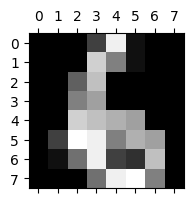

6


In [2]:
data = load_digits()

X = data["data"]
# В качестве целевой переменной индикатор того, больше число 5 или нет. Таким образом, сводим задачу к бинарной классификации.
y = (data["target"] >= 5).astype(np.int32)

plt.figure(figsize=(2, 2))
plt.gray()
index = np.random.randint(0, len(X) - 1)
plt.matshow(X[index].reshape(8, 8), fignum=1)
plt.show()
print(data.target[index])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, shuffle=True)
X_train.shape, X_test.shape

((1186, 64), (611, 64))

### Логистическая регрессия

Вычисление предсказания логистической регрессией для объекта $x_i \in \mathbb{R}^n$ :

* $f = w^T x_i + b, \quad w \in \mathbb{R}^n, b \in \mathbb{R}$
* $a = \sigma (f)$

Сигмоида:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

![alt text](https://upload.wikimedia.org/wikipedia/commons/a/ac/Logistic-curve.png)

Логистическая фунция потерь:

$$L_i(a) = -y_i \cdot log(a) - (1 - y_i) \cdot log(1 - a)$$

Производные функции по параметрам:

$$\frac{\partial L}{\partial w} = \frac{1}{m}\sum_{i=1}^{m} \frac{\partial L_i}{\partial w}$$

$$\frac{\partial L_i}{\partial w} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial w} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot x_i = (a-y_i) \cdot x_i $$

$$\frac{\partial L}{\partial b} = \frac{1}{m}\sum_{i=1}^{m} \frac{\partial L_i}{\partial b}$$

$$\frac{\partial L_i}{\partial b} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial b} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot 1 = a-y_i $$

Используются для минимизации функции потерь $L$ с помощью градиентного спуска:

$$w_{j+1} = w_j - \alpha \cdot \nabla \frac{\partial L}{\partial w}(w_j, b_j)$$

$$b_{j+1} = b_j - \alpha \cdot \nabla \frac{\partial L}{\partial b}(w_j, b_j)$$

In [4]:
class LogisticRegression:
    """Класс логистической регрессии."""

    def __init__(self, learning_rate=0.005, epochs=1, report_interval=1):
        self.learning_rate = learning_rate  # шаг обучения
        self.epochs = epochs  # кол-во шагов градиентного спуска
        self.report_interval = report_interval  # через какой интервал считать характеристики

        self.num_obj = None  # кол-во объектов в обучающем наборе
        self.num_feat = None  # кол-во признаков
        self.weights = None  # веса
        self.bias = None  # свободный член
        # Списки ошибок.
        self.losses_train = None
        self.losses_test = None

    @staticmethod
    def __log_loss(y_true, y_pred):
        """Логистическая функция потерь."""
        return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred), axis=0) / len(y_true)

    @staticmethod
    def __sigmoid(x):
        """Сигмоида."""
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y, eval_set=None):
        """Метод обучения модели."""

        # Количество объектов и признаков.
        self.num_obj, self.num_feat = X.shape
        # Инициализация весов (вектор 1 x num_feat) и свободного члена по закону нормального распределения.
        self.weights = np.random.randn(self.num_feat, 1) * 0.001
        self.bias = np.random.randn() * 0.001
        if eval_set is not None:
            self.losses_train = []
            self.losses_test = []

        # Эпохи - кол-во проходов по всему набору данных или кол-во шагов по антиградиенту.
        for epoch in range(self.epochs):
            # Инициализация градиента.
            grad_w = np.zeros((self.num_feat, 1))
            grad_b = 0
            
            # Цикл по всем объектам.
            for i in range(self.num_obj):
                # Линейная комбинация признаков.
                # Матричное произведение Xi (1 x num_feat) на w (num_feat x 1) плюс bias.
                f = (X[i].reshape(1, self.num_feat).dot(self.weights) + self.bias)[0][0]  # f - скаляр
                # Результат подаётся на вход сигмоиде.
                a = self.__sigmoid(f)
                # Расчёт градиента.
                grad_w += (a - y[i]) * X[i].reshape(self.num_feat, 1)
                grad_b += (a - y[i])

            # Усреднение градиента.
            grad_w /= self.num_obj
            grad_b /= self.num_obj

            # Корректировка весов и свободного члена. Шаг в сторону антиградиента.
            self.weights = self.weights - self.learning_rate * grad_w
            self.bias = self.bias - self.learning_rate * grad_b

            # Сохранение ошибки для графика.
            if epoch % self.report_interval == 0 and eval_set is not None:
                self.losses_train.append(self.__log_loss(y, self.predict(X)))
                self.losses_test.append(self.__log_loss(eval_set[1], self.predict(eval_set[0])))

    def fit_vec(self, X, y, eval_set=None):
        """Метод обучения с использованием векторизации."""

        # Количество объектов и признаков.
        self.num_obj, self.num_feat = X.shape
        # Инициализация весов (вектор 1 x num_feat) и свободного члена по закону нормального распределения.
        self.weights = np.random.randn(self.num_feat, 1) * 0.001
        self.bias = np.random.randn() * 0.001
        if eval_set is not None:
            self.losses_train = []
            self.losses_test = []

        # Эпохи - кол-во проходов по всему набору данных или кол-во шагов по антиградиенту.
        for epoch in range(self.epochs):
            # Линейная комбинация признаков.
            F = X.dot(self.weights) + self.bias
            # Результат подаётся на вход сигмоиде.
            A = self.__sigmoid(F)

            # Расчёт градиента.
            grad_w = np.sum((A.reshape(self.num_obj, 1) - y.reshape(self.num_obj, 1)) * X, axis=0) / self.num_obj
            grad_b = np.sum((A.reshape(self.num_obj, 1) - y.reshape(self.num_obj, 1)), axis=0) / self.num_obj

            # Корректировка весов и свободного члена. Шаг в сторону антиградиента.
            self.weights = self.weights - self.learning_rate * grad_w.reshape(self.num_feat, 1)
            self.bias = self.bias - self.learning_rate * grad_b

            # Сохранение ошибки для графика.
            if epoch % self.report_interval == 0 and eval_set is not None:
                self.losses_train.append(self.__log_loss(y, self.predict(X)))
                self.losses_test.append(self.__log_loss(eval_set[1], self.predict(eval_set[0])))

    def predict(self, X):
        """Функция предсказаний."""
        return np.array([self.__sigmoid((x.reshape(1, self.num_feat).dot(self.weights) + self.bias)[0][0]) for x in X])

### Используя цикл

In [5]:
%%time
model = LogisticRegression(epochs=500, report_interval=50)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

CPU times: total: 7.27 s
Wall time: 7.29 s


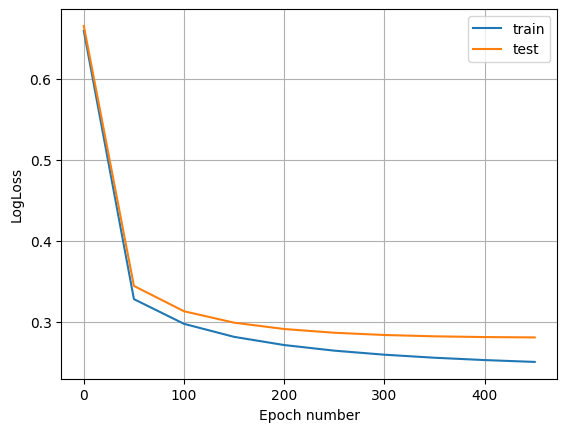

In [6]:
epoch_numbers = np.arange(0, len(model.losses_train)) * model.report_interval

plt.plot(epoch_numbers, model.losses_train, label="train")
plt.plot(epoch_numbers, model.losses_test, label="test")
plt.xlabel("Epoch number")
plt.ylabel("LogLoss")
plt.legend()
plt.grid(True)

In [7]:
test_prediction = model.predict(X_test)
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f"Test accuracy: {round(test_accuracy, 3)}")

Test accuracy: 0.9


In [8]:
train_prediction = model.predict(X_train)
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f"Train accuracy: {round(train_accuracy, 3)}")

Train accuracy: 0.909


### Используя векторизацию

In [9]:
%%time
model = LogisticRegression(epochs=500, report_interval=50)
model.fit_vec(X_train, y_train, eval_set=(X_test, y_test))

CPU times: total: 406 ms
Wall time: 415 ms


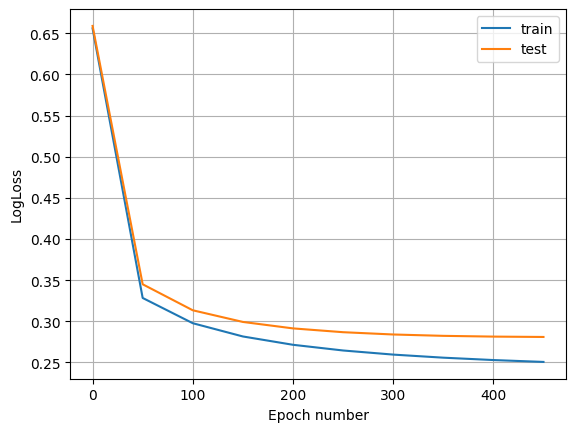

In [10]:
epoch_numbers = np.arange(0, len(model.losses_train)) * model.report_interval

plt.plot(epoch_numbers, model.losses_train, label="train")
plt.plot(epoch_numbers, model.losses_test, label="test")
plt.xlabel("Epoch number")
plt.ylabel("LogLoss")
plt.legend()
plt.grid(True)

In [11]:
test_prediction = model.predict(X_test)
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f"Test accuracy: {round(test_accuracy, 3)}")

Test accuracy: 0.9


In [12]:
train_prediction = model.predict(X_train)
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f"Train accuracy: {round(train_accuracy, 3)}")

Train accuracy: 0.908


### Модель с двумя признаками

In [13]:
def gen_cluster(dots, radius=1, center=(0, 0)):
    """Генерирует равномерное распределение точек внутри окружности с заданным радиусом и центром."""
    x_1 = radius * (2 * np.random.random(dots) - 1)
    x_2 = np.array([((radius ** 2 - val ** 2) ** 0.5) * (2 * np.random.random() - 1) for val in x_1])
    return [x_1 + center[0], x_2 + center[1]]

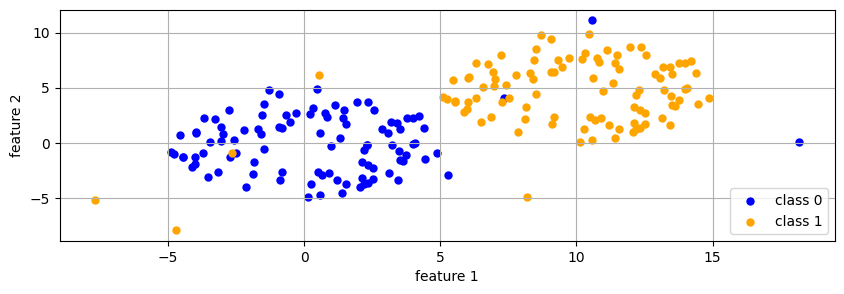

In [14]:
num_dots = 100  # число точек в каждом кластере
num_anom = int(0.05 * num_dots)  # число аномальных точек
radius = 5
center_1 = (0, 0)
center_2 = (10, 5)

# Первоначальные кластеры.
cluster_1 = gen_cluster(num_dots - num_anom, radius, center_1)
cluster_2 = [cluster_1[0] + center_2[0], cluster_1[1] + center_2[1]]

# Аномальные точки.
anom_2 = gen_cluster(num_anom, 2 * radius, center_1)
anom_1 = [anom_2[0] + center_2[0], anom_2[1] + center_2[1]]

# Объединение кластеров с аномальными точками.
cluster_1[0], cluster_1[1] = np.concatenate((cluster_1[0], anom_1[0])), np.concatenate((cluster_1[1], anom_1[1]))
cluster_2[0], cluster_2[1] = np.concatenate((cluster_2[0], anom_2[0])), np.concatenate((cluster_2[1], anom_2[1]))

plt.figure(figsize=(10, 3))
plt.scatter(cluster_1[0], cluster_1[1], linewidths=0.01, color="blue")
plt.scatter(cluster_2[0], cluster_2[1], linewidths=0.01, color="orange")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["class 0", "class 1"], loc ="lower right")
plt.grid(True)
plt.show()

In [15]:
X = np.column_stack((
    np.concatenate((cluster_1[0], cluster_2[0])),  # feature 1
    np.concatenate((cluster_1[1], cluster_2[1])),  # feature 2
    np.concatenate((np.zeros(num_dots), np.ones(num_dots)))  # отклик
))

np.random.shuffle(X)  # перемешиваем строки
y = X[:, X.shape[1] - 1]  # сохраняем отклик
X = np.delete(X, obj=X.shape[1] - 1, axis=1)  # удаляем отклик

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, shuffle=True)
X_train.shape, X_test.shape

((132, 2), (68, 2))

In [16]:
%%time
model = LogisticRegression(learning_rate=0.05, epochs=1500, report_interval=10)
model.fit_vec(X_train, y_train, eval_set=(X_test, y_test))

CPU times: total: 391 ms
Wall time: 378 ms


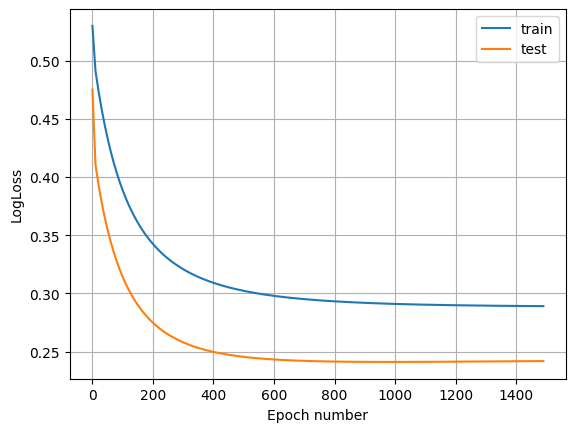

In [17]:
epoch_numbers = np.arange(0, len(model.losses_train)) * model.report_interval

plt.plot(epoch_numbers, model.losses_train, label="train")
plt.plot(epoch_numbers, model.losses_test, label="test")
plt.xlabel("Epoch number")
plt.ylabel("LogLoss")
plt.legend()
plt.grid(True)

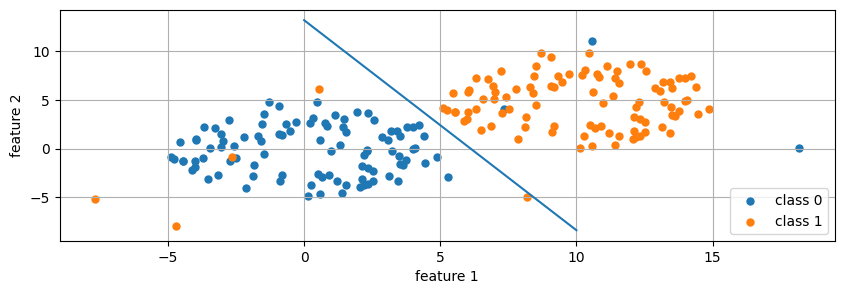

In [18]:
# Разделяющая линия.
div_line_x = np.linspace(0, 10, num_dots)
div_line_y = -(model.weights[0] * div_line_x + model.bias) / model.weights[1]  # рещение уравнения w1 * x + w2 * y + bias = 0

plt.figure(figsize=(10, 3))
plt.scatter(cluster_1[0], cluster_1[1], linewidths=0.01)
plt.scatter(cluster_2[0], cluster_2[1], linewidths=0.01)
plt.plot(div_line_x, div_line_y)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["class 0", "class 1"], loc="lower right")
plt.grid(True)
plt.show()

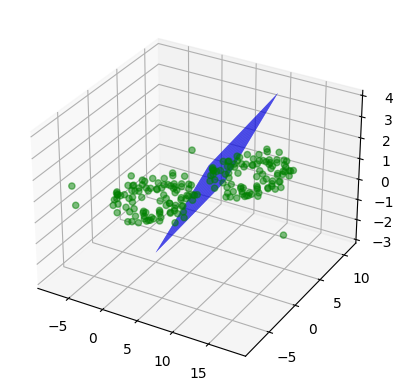

In [19]:
# Разделяющая поверхность.
u = np.linspace(0, 10, num_dots)
div_surf_x, div_surf_y = np.meshgrid(u, u)
div_surf_z = model.weights[0] * div_surf_x + model.weights[1] * div_surf_y + model.bias  # w1 * x + w2 * y + bias = z

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(X.transpose()[0], X.transpose()[1], y, color="green", alpha=0.5)
ax.plot_surface(div_surf_x, div_surf_y, div_surf_z, alpha=1, color="blue")

In [20]:
test_prediction = model.predict(X_test)
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f"Test accuracy: {round(test_accuracy, 3)}")

Test accuracy: 0.956


In [21]:
train_prediction = model.predict(X_train)
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f"Train accuracy: {round(train_accuracy, 3)}")

Train accuracy: 0.962
